In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class LogisticRegression:
    
    def __init__(self, percentage=0.5, lr=0.01, max_iter=10000, beta=0.99, reg_term=0):  # percentage = train/cv+test split
        self.percentage = percentage
        self.gradient_values, self.train_acc_values, self.cv_acc_values = [], [], []
        self.cv_acc, self.select_line = 0, 0
        self.learning_rate = lr
        self.max_iter = max_iter
        self.beta = beta
        self.reg_term = reg_term
#         if train_X is None and test_X is None:
#             self.train_X, self.train_y, self.sub_X, self.sub_y = self.split_data(self.data, self.percentage)
#         else:
#             self.train_X, self.train_y, self.sub_X, self.sub_y = train_X, train_y, test_X, test_y
            
#         self.test_X, self.test_y, self.cv_X, self.cv_y = self.split_data(pd.concat([self.sub_X,self.sub_y], axis=1), 0.5)
#         self.train_X, self.train_y, self.cv_X, self.cv_y = train_X, train_y, test_X, test_y
        
#         self.thetas = self.gradient_descent(self.train_X.values, self.train_y.values, self.cv_X.values, self.cv_y.values, learning_rate=lr, max_iter=max_iter, beta=beta, reg_term=reg_term)
        
#         self.testing_accuracy = self.get_test_acc(self.test_X.values, self.test_y.values, self.thetas)
        

    
    def predict_proba(self, X, theta):
        return self.sigmoid(np.dot(X, theta))

    def predict(self, X, theta):
        prediction = self.predict_proba(X, theta)
        predict_arr = []
        for i in prediction:
            if i>=0.5:
                predict_arr.append(1)
            else:
                predict_arr.append(0)

        return predict_arr
    
    def multiclass_predict(self, X, theta):
        prediction = self.predict_proba(X, theta)
        predict_arr = []
        for i in prediction:
            predict_arr.append(np.argmax(i))
#             if i>=0.5:
#                 predict_arr.append(1)
#             else:
#                 predict_arr.append(0)
        return predict_arr

    def accuracy(self, predict_arr, y):
        correct = 0
        for i,j in zip(predict_arr, y):
            if i==j[0]:
                correct+=1
        return correct/len(y)  # accuracy = # tp+tn / total
    
    def multiclass_accuracy(self, predict_arr, y):
        correct = 0
        for i,j in zip(predict_arr, y):
            if i == np.argmax(j.toarray()):
                correct+=1
        return correct/len(predict_arr)
        

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def softmax(self, Z):
        z0 = z-np.max(z, 0)
        yh = np.exp(z)
        yh /= np.sum(yh, 0)
        return yh

    def gradient(self, X, y, theta, lambdaa):  # lambdaa is regularization term
        N, D = len(X[0]), len(X[0])
        yh = self.sigmoid(np.dot(X, theta))
        grad = np.dot(X.T, yh-y) / N
        grad[1:] += lambdaa * theta[1:]
        return grad

    def fit(self, X, y, cv_X, cv_y, multiclass, learning_rate=0.1, max_iter=10000, beta=0.99, reg_term=0.5):  # attempted termination condition - lack of improvement in cross validation set
        learning_rate = self.learning_rate
        max_iter = self.max_iter
        beta = self.beta
        reg_term = self.reg_term
        N, D = len(X[0]), len(X[0])
        theta = np.zeros((len(X[0]), 1))
        y = np.reshape(y, (-1,1))  # creates two-dimensional array
        cv_y = np.reshape(cv_y, (-1,1))
        if multiclass is True:
            onehotencoder = OneHotEncoder(categories='auto')
            y = onehotencoder.fit_transform(y)
            cv_y = onehotencoder.transform(cv_y)
        iterate, cv_acc, prev_cv_acc, d_theta = 0, 0, 0, 0
        max_cv_acc = 0  # maximum cross validation accuracy - records thetas at highest cv_acc 
        best_theta = theta
        g = np.inf
        eps = 1e-2
        while (np.linalg.norm(g) > eps):  # can add in 'or cv_acc>=prev_cv_acc-0.03' to stop when gradient becomes too small, 0.03 gives buffer
            g = self.gradient(X, y, theta, reg_term)
            d_theta = (1-beta)*g + beta*d_theta  # momentum
            theta = theta-learning_rate*d_theta
            
            if iterate % 10 == 0:
                if multiclass is True:
                    cv_pred = self.multiclass_predict(cv_X, theta)
                    train_pred = self.multiclass_predict(X, theta)
                    prev_cv_acc = cv_acc
                    cv_acc = self.multiclass_accuracy(cv_pred, cv_y)
                    train_acc = self.multiclass_accuracy(train_pred, y)
                else: 
                    cv_pred = self.predict(cv_X, theta)
                    train_pred = self.predict(X, theta)
                    prev_cv_acc = cv_acc
                    cv_acc = self.accuracy(cv_pred, cv_y)
                    train_acc = self.accuracy(train_pred, y)
                
                
                
                
            if cv_acc >= max_cv_acc:  # checks if maximum accuracy thus far
                max_cv_acc = cv_acc
                best_theta = theta
                self.select_line = iterate
            iterate+=1
            self.gradient_values.append(np.linalg.norm(g))
            self.train_acc_values.append(train_acc)
            self.cv_acc_values.append(cv_acc)
#             if iterate % 100 == 0:
#                 print(np.linalg.norm(g)/len(X))
            if iterate > max_iter:  # since it may not always converge, place a hard ceiling on number of iterations
                break
        print(max_cv_acc)
        print(cv_acc)
        self.cv_acc = max_cv_acc
        return best_theta
    
    def get_test_acc(self, test_X, test_y, thetas):
        test_y = np.reshape(test_y, (-1,1))
        
        return self.accuracy(self.predict(test_X, thetas), test_y)

In [3]:
def split_data(data, percentage=0.5):
    val = np.random.rand(len(data)) < percentage  #splits data and sorts into x, y values
    train = data[val]
    test = data[~val]

    train_X = train.iloc[:, :-1]
    train_y = train.iloc[:, -1]

    test_X = test.iloc[:, :-1]
    test_y = test.iloc[:, -1]
    return train_X, train_y ,test_X, test_y

0.8571428571428571
0.8428571428571429


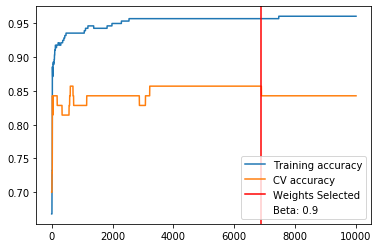

0.9130434782608695
0.9130434782608695


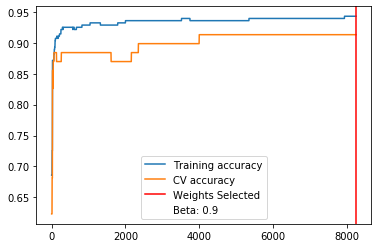

0.8985507246376812
0.8985507246376812


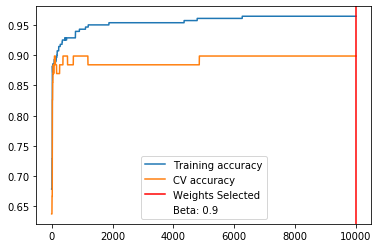

0.927536231884058
0.8985507246376812


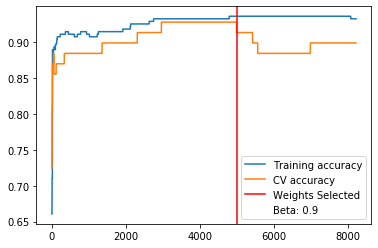

0.8714285714285714
0.8714285714285714


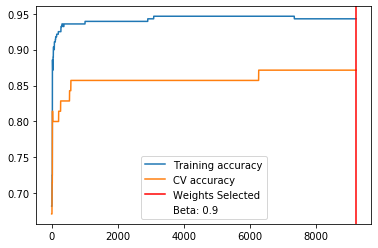

Average Accuracy: 0.8935403726708074
0.8571428571428571
0.8428571428571429


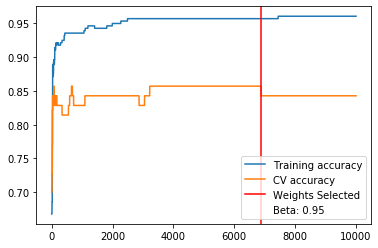

KeyboardInterrupt: 

In [50]:
new_input = pd.read_csv('ionosphere.data', header=None)
new_input[len(new_input.T)-1] = new_input[len(new_input.T)-1].map({'g': 1, 'b':0})
new_input.insert(0, column='Bias', value=1)
new_input = new_input.sample(frac=1)  # randomly shuffles dataset

folds = 5
accuracies = []
learning_rate = [0.9, 0.95, 0.99]
for lr in learning_rate:
    for i in range(folds):

        start_bias = 0
        end_bias = 1
        if i>0:
            start_bias = 1  # to exclude last term in previous partition
        if i >= folds-1:
            end_bias = 0
        percentage = 1/folds
        length = len(new_input[0])
        test_set = new_input.iloc[int(percentage*(i)*length+start_bias):int(percentage*(i+1)*length), :]

        train_set_1 = new_input.iloc[int(percentage*(i+1)*length)+end_bias:len(new_input[0]), :]
        train_set_2 = new_input.iloc[0:int(percentage*(i)*length), :]
        train_set = pd.concat([train_set_1, train_set_2])

        train_X = train_set.iloc[:, :-1]
        train_y = train_set.iloc[:, -1]

        test_X = test_set.iloc[:, :-1]
        test_y = test_set.iloc[:, -1]

    # i_train_X, i_train_y, i_test_X, i_test_y = split_data(new_input)


        log_reg = LogisticRegression(percentage=0.6, beta = lr, lr = 0.1, reg_term = 0)
        log_reg.fit(train_X.values, train_y.values, test_X.values, test_y.values, False)
        accuracies.append(log_reg.cv_acc)
        plt.figure()
        plt.plot(log_reg.train_acc_values, label = 'Training accuracy')
        plt.plot(log_reg.cv_acc_values, label='CV accuracy')
        plt.axvline(log_reg.select_line, color='r', label='Weights Selected')
        plt.plot([], [], ' ', label="Beta: "+str(log_reg.beta))
        plt.legend()
        plt.show()
    print("Average Accuracy: "+str(np.mean(accuracies)))

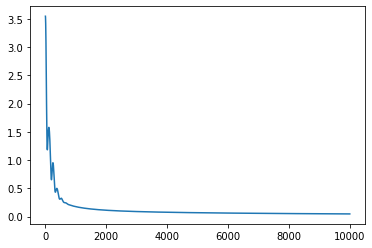

In [5]:
plt.figure(101)
plt.plot(log_reg.gradient_values)
plt.show()

In [28]:
header = ['age','workclass','fnlwgt','education','education_num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
train_df = pd.read_csv('adult.data', names = header)
train_df.insert(0, column='Bias', value=1)
test_df = pd.read_csv('adult.test', comment = '|', names = header)
test_df.insert(0, column='Bias', value=1)
adult = pd.concat([test_df, train_df])

adult.isnull().sum() #no NaN 

for i,j in zip(adult.columns,(adult.values.astype(str) == ' ?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' missing')
        
all_data = [train_df, test_df]
for data in all_data:
    for i in data.columns:
        data[i].replace(' ?', np.nan, inplace=True)
    data.dropna(inplace=True)
    
adult['income']=adult['income'].map({' <=50K': 0, ' >50K': 1, ' <=50K.': 0, ' >50K.': 1})

train_df['income'] = train_df['income'].map({' <=50K': 0, ' >50K': 1})
test_df['income'] = test_df['income'].map({' <=50K.': 0, ' >50K.': 1}) 

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [2,4,6,7,8,9,10,14])], remainder='passthrough')
onehotencoder = OneHotEncoder()
X_train_adult = columnTransformer.fit_transform(train_df).toarray()
X_test_adult = columnTransformer.transform(test_df).toarray()


y_train_adult = train_df.iloc[:,-1]
y_test_adult = test_df.iloc[:,-1]
# Encode '<=50k' as 0, '>50k' as 1

# y_train_adult = y_train_adult.map({' <=50K': 0, ' >50K': 1})
# y_test_adult = y_test_adult.map({' <=50K.': 0, ' >50K.': 1})
# y_train_adult=y_train_adult.array
# y_test_adult=y_test_adult.array

workclass: 2799 missing
occupation: 2809 missing
native-country: 857 missing


In [100]:
# y_test_adult = y_test_adult[:-1]
# y_train_adult = y_train_adult[:-1]
new_X_train_adult = pd.DataFrame(data = X_train_adult, index = [index for index, row in y_train_adult.iteritems()], columns = [i for i in range(X_train_adult.shape[1])])
new_X_test_adult = pd.DataFrame(data = X_test_adult, index = [index for index, row in y_test_adult.iteritems()], columns = [i for i in range(X_test_adult.shape[1])])
def df_rescale(data):
    for col in range(len(data.columns)):
#         print(col)
        this_max = data.iloc[:, col].max()
        this_min = data.iloc[:, col].min()
        if (this_max != this_min):
            data.iloc[:, col] -= this_min
            data.iloc[:, col] /= data.iloc[:, col].max()
    return data

new_X_train_adult = df_rescale(new_X_train_adult)
new_X_test_adult = df_rescale(new_X_test_adult)

In [162]:
new_X_test_adult.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.109589,0.144430,0.400000,0.000000,0.0,0.397959,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.287671,0.051677,0.533333,0.000000,0.0,0.500000,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.150685,0.219011,0.733333,0.000000,0.0,0.397959,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.369863,0.099418,0.600000,0.076881,0.0,0.397959,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.232877,0.125398,0.333333,0.000000,0.0,0.295918,0.0


In [10]:
import time

0.8506299734748011
0.8502984084880637


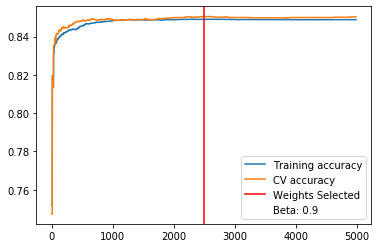

100.06752228736877
0.8492787265793401
0.8491129165975791


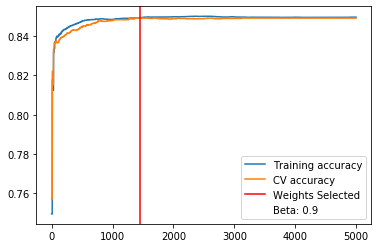

428.6157479286194
0.8514588859416445
0.8494694960212201


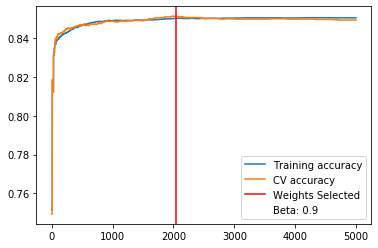

424.0593616962433
0.8479522467252528
0.8472890067982093


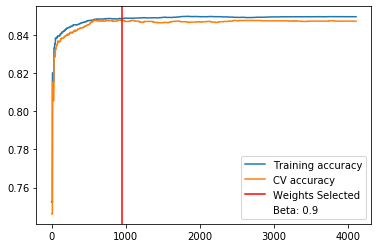

349.98370337486267
0.8466511936339522
0.8466511936339522


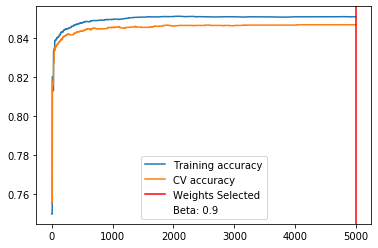

85.48398160934448
Average Test Accuracy: 0.8473837981407701
Average Accuracy: 0.8491942052709982
0.8506299734748011
0.8502984084880637


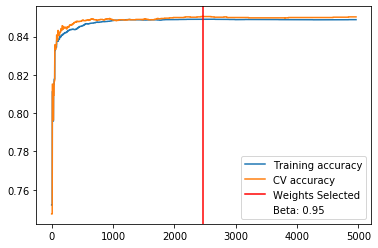

85.32719111442566
0.8492787265793401
0.8491129165975791


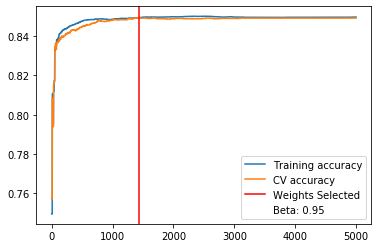

414.2390377521515
0.8514588859416445
0.8494694960212201


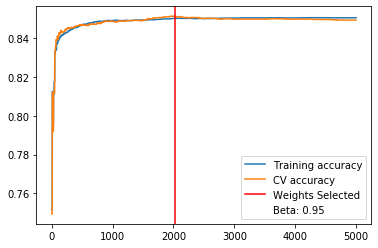

410.6660373210907
0.8479522467252528
0.8472890067982093


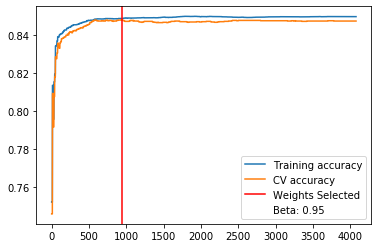

330.58116912841797
0.8466511936339522
0.8466511936339522


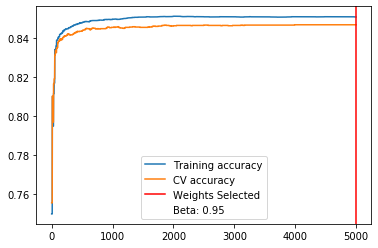

84.8880968093872
Average Test Accuracy: 0.8473837981407704
Average Accuracy: 0.8491942052709982
0.8509615384615384
0.8502984084880637


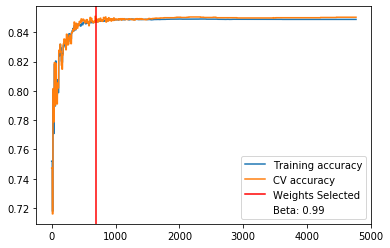

80.99267578125
0.8492787265793401
0.8489471066158183


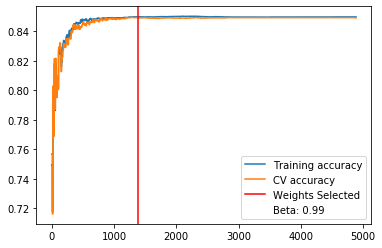

397.67408418655396
0.8514588859416445
0.8493037135278515


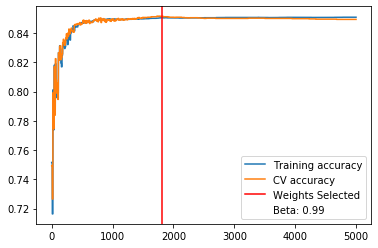

408.2499506473541
0.8486154866522965
0.8472890067982093


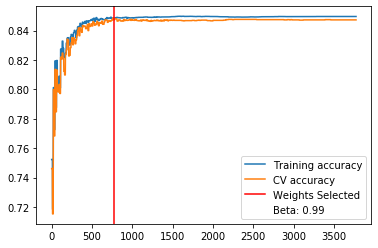

308.9236013889313
0.8466511936339522
0.8464854111405835


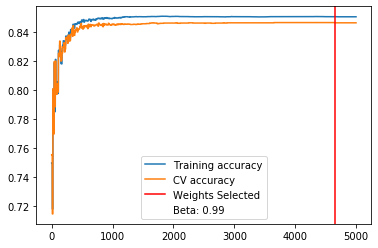

86.099196434021
Average Test Accuracy: 0.8472509960159363
Average Accuracy: 0.8492605255985837


In [59]:
new_X_train_adult = new_X_train_adult.sample(frac=1)  # randomly shuffles dataset

folds = 5
a_accuracies = []
test_accuracies = []
learning_rate = [0.9, 0.95, 0.99]
for lr in learning_rate:
    for i in range(folds):
        start_time = time.time()
        start_bias = 0
        end_bias = 1
        if i>0:
            start_bias = 1  # to exclude last term in previous partition
        if i >= folds-1:
            end_bias = 0
        percentage = 1/folds
        length = len(new_X_train_adult[0])
        test_set_adult = new_X_train_adult.iloc[int(percentage*(i)*length+start_bias):int(percentage*(i+1)*length), :]
        train_set_1_adult = new_X_train_adult.iloc[int(percentage*(i+1)*length)+end_bias:len(new_X_train_adult[0]), :]
        train_set_2_adult = new_X_train_adult.iloc[0:int(percentage*(i)*length), :]
        train_set_adult = pd.concat([train_set_1_adult, train_set_2_adult])

        train_X_adult = train_set_adult.iloc[:, :-1]
        train_y_adult = train_set_adult.iloc[:, -1]

        test_X_adult = test_set_adult.iloc[:, :-1]
        test_y_adult = test_set_adult.iloc[:, -1]
        
        adult_log_reg = LogisticRegression(percentage=0.6, beta = lr, max_iter=5000, lr=0.1, reg_term=0)
        new_thetas = adult_log_reg.fit(train_X_adult.values, train_y_adult.values, test_X_adult.values, test_y_adult.values, False)
        a_accuracies.append(adult_log_reg.cv_acc)
        test_accuracies.append(adult_log_reg.get_test_acc(new_X_test_adult.iloc[:, :-1], new_X_test_adult.iloc[:, -1].values, new_thetas))
        plt.figure()
        plt.plot(adult_log_reg.train_acc_values, label = 'Training accuracy')
        plt.plot(adult_log_reg.cv_acc_values, label='CV accuracy')
        plt.axvline(adult_log_reg.select_line, color='r', label='Weights Selected')
        plt.plot([], [], ' ', label="Beta: "+str(adult_log_reg.beta))
        plt.legend()
        plt.show()
        print(time.time() - start_time)
    print("Average Test Accuracy: " +str(np.mean(test_accuracies)))
    print("Average Accuracy: "+str(np.mean(a_accuracies)))

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5705329153605015
0.5642633228840125


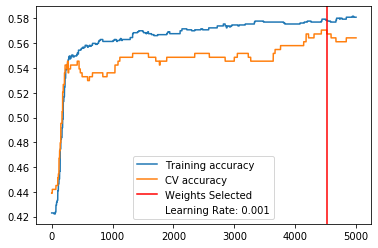

208.5906617641449


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5862068965517241
0.5862068965517241


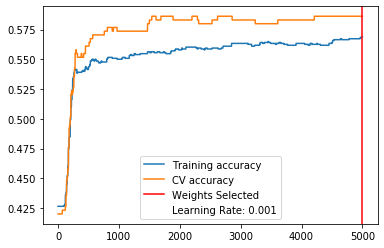

208.12894320487976


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5235109717868338
0.5235109717868338


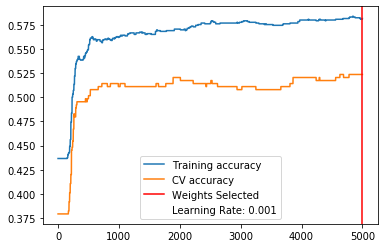

203.80014038085938


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6081504702194357
0.6018808777429467


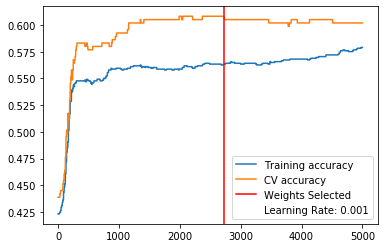

142.69979763031006


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5830721003134797
0.5830721003134797


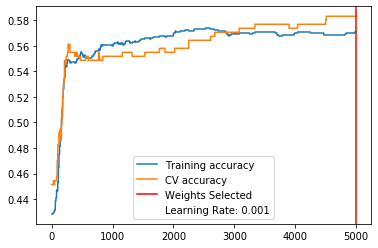

119.49994230270386
Average Accuracy: 0.574294670846395


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5768025078369906
0.5736677115987461


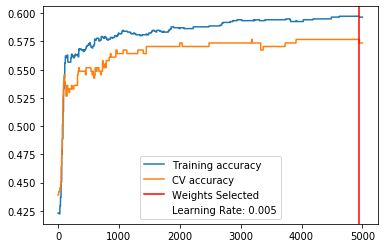

120.20995426177979


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6050156739811913
0.6018808777429467


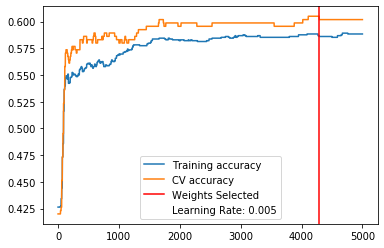

120.56792259216309


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5454545454545454
0.5454545454545454


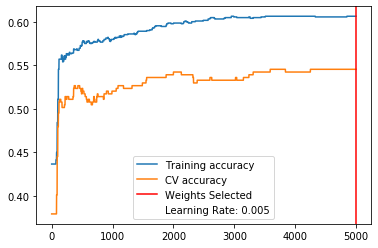

118.97189736366272


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6300940438871473
0.6175548589341693


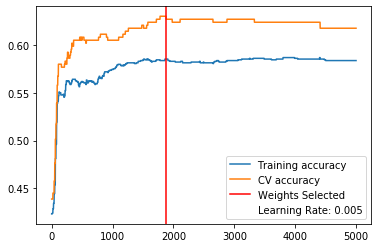

119.60992074012756


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5924764890282131
0.5924764890282131


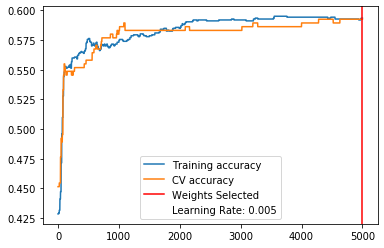

120.1989676952362
Average Accuracy: 0.5821316614420062


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5830721003134797
0.5830721003134797


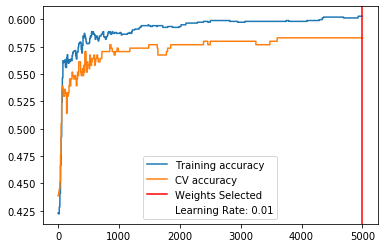

119.98099780082703


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6081504702194357
0.6081504702194357


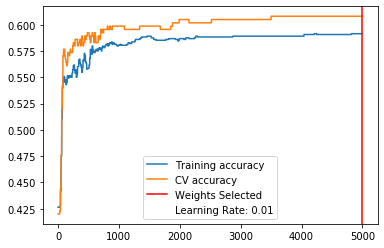

119.69030904769897


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.554858934169279
0.554858934169279


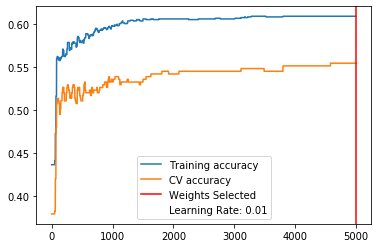

119.51968574523926


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6300940438871473
0.6206896551724138


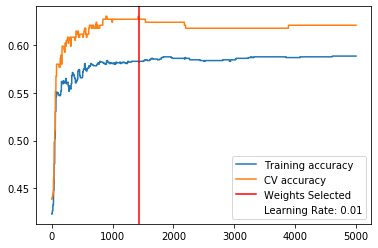

119.660391330719


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5924764890282131
0.5924764890282131


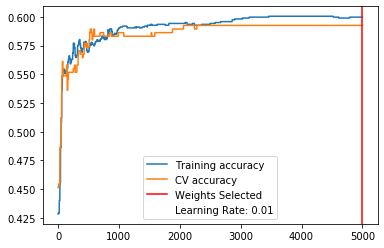

119.43986344337463
Average Accuracy: 0.5859979101358411


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6018808777429467
0.5736677115987461


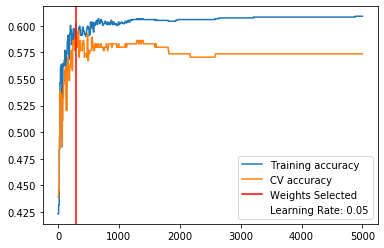

119.04003715515137


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6269592476489029
0.6050156739811913


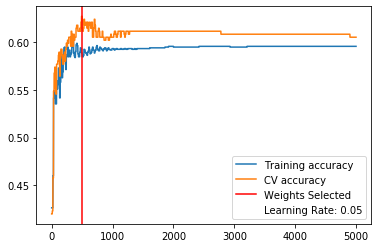

120.08998537063599


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5611285266457681
0.554858934169279


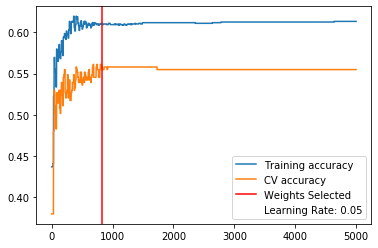

120.37012529373169


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6426332288401254
0.6269592476489029


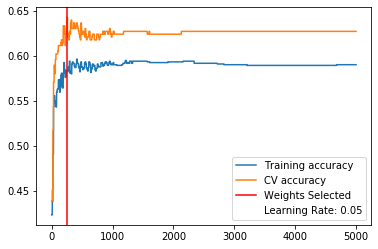

118.97866368293762


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6050156739811913
0.5956112852664577


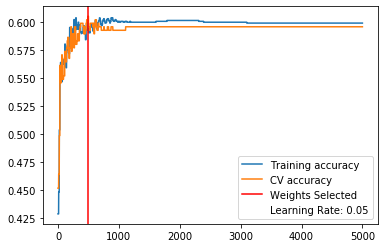

119.23008823394775
Average Accuracy: 0.5913793103448277


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5956112852664577
0.5736677115987461


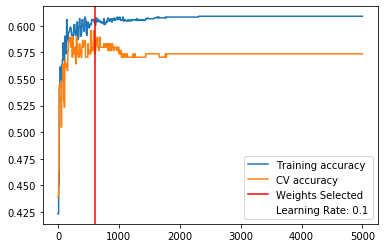

127.67005586624146


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6238244514106583
0.6081504702194357


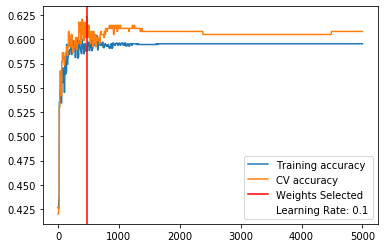

176.33972716331482


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.5611285266457681
0.554858934169279


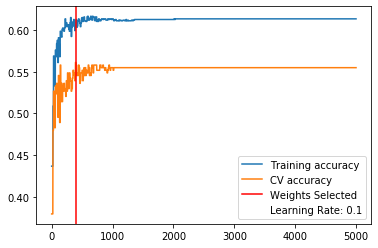

179.9218451976776


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6426332288401254
0.6238244514106583


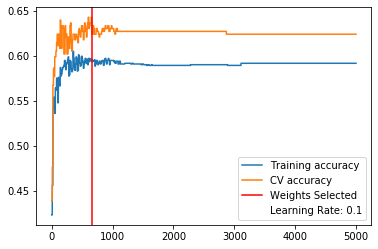

160.74609184265137


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6112852664576802
0.5956112852664577


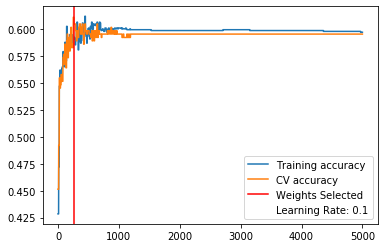

186.7051603794098
Average Accuracy: 0.5944827586206896


In [105]:
wine_input = pd.read_csv('winequality-red.csv', delimiter=";")
# for column in wine_df.columns[:-1]:
#     wine_df[column] = (wine_df[column] - wine_df[column].mean()) / wine_df[column].std()

# wine_input = wine_df.drop(['quality'], axis=1)
wine_input.iloc[:, :-1] = df_rescale(wine_input.iloc[:, :-1])
wine_input.insert(0, column='Bias', value=1)
wine_input = wine_input.sample(frac=1)



folds = 5
accuracies = []
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1]
for lr in learning_rate:
    for i in range(folds):
        start_time = time.time()
        start_bias = 0
        end_bias = 1
        if i>0:
            start_bias = 1  # to exclude last term in previous partition
        if i >= folds-1:
            end_bias = 0
        percentage = 1/folds
        length = len(wine_input)
        test_set = wine_input.iloc[int(percentage*(i)*length+start_bias):int(percentage*(i+1)*length), :]

        train_set_1 = wine_input.iloc[int(percentage*(i+1)*length)+end_bias:length, :]
        train_set_2 = wine_input.iloc[0:int(percentage*(i)*length), :]
        train_set = pd.concat([train_set_1, train_set_2])
        
        train_X = train_set.iloc[:, :-1]
        train_y = train_set.iloc[:, -1]

        test_X = test_set.iloc[:, :-1]
        test_y = test_set.iloc[:, -1]
        
        log_reg = LogisticRegression(percentage=0.6, lr = lr, max_iter = 5000)
        log_reg.fit(train_X.values, train_y.values, test_X.values, test_y.values, True)
        accuracies.append(log_reg.cv_acc)
        plt.figure()
        plt.plot(log_reg.train_acc_values, label = 'Training accuracy')
        plt.plot(log_reg.cv_acc_values, label='CV accuracy')
        plt.axvline(log_reg.select_line, color='r', label='Weights Selected')
        plt.plot([], [], ' ', label="Learning Rate: "+str(log_reg.learning_rate))
        plt.legend()
        plt.show()
        print(time.time()-start_time)
    print("Average Accuracy: "+str(np.mean(accuracies)))

In [104]:
adult_time_arr = [[84.41927528381348, 409.7918200492859, 407.89065074920654, 410.2709047794342, 83.74086093902588], [84.63676285743713, 407.54512906074524, 411.53678727149963, 411.892466545105, 84.52902054786682],
                 [84.09255743026733, 408.6802990436554, 409.2142460346222, 409.39416790008545, 83.12499618530273], [84.61924505233765, 407.3097414970398, 397.17783546447754, 394.8758919239044, 82.24552273750305],
                 [59.074816942214966, 401.5954577922821, 407.9469916820526, 409.6232545375824, 82.65668821334839]]

for lr in adult_time_arr:
    print(np.mean(lr))

279.2227023601532
280.02803325653076
278.90125331878664
273.24564733505247
272.17944183349607
